In [ ]:
# Exploring approaches to feature engineerin and class prediction on State Department Human Rights reports

## 1 : 

In [1006]:
import pandas as pd
import sqlite3 as sql

# 0 :  Define some NLP ceanin functions for later use

In [1089]:
import re
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

stopWords.add('kill')
stopWords.add('killing')
stopWords.add('killings')

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.util import ngrams

def convert(list): 
      
    # Converting integer list to string list 
    s = [str(i) for i in list] 
    
    # Join list items using join()
    s = (" ".join(s)) 
    

    return(s) 


def clean_text(s):
    
    # Convert to lowercase
    s = s.lower()
    
    # Remove aposrphe
    s =s.replace("'", "")
    
    s = s.replace('\n',' ')
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)

    # Repace all punctuatin with spaces
    s = re.sub(r'[^\w\s]',' ',s)

    # replace all double spaces, tabes, and returns
    s= re.sub(' +', ' ',s)
    
    
    
    return(s)



def stem_word(text):
    
    stemmed = []
    stemmer = LancasterStemmer()
    
    for w in text:
        stemmed.append(stemmer.stem(w))
        
    return (stemmed)


def generate_ngrams(st, n):
    
   
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    #tokens = remove_stops(tokens)
    #tokens = stem_word(tokens)
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]




def word_grams(words, min=1, max=4):
    s = []
    for n in range(min, max):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethwalker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1.0: Import 1a Africa Data

In [1008]:
# connect to MS_hackathon.db within the data/ directory, makes it if it doesn't exist
conn = sql.connect('../data/MS_hackathon.db')

In [1009]:
c = conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('CIRI',), ('section1a_africa',), ('GapMinderData',)]


In [1010]:

c.execute('select * from section1a_africa;')
names = list(map(lambda x: x[0], c.description))
print(names)




['index', 'CountryName', 'Report']


In [1021]:
c.execute("SELECT * FROM section1a_africa;")
section_corpus = c.fetchall()
selection = pd.DataFrame(section_corpus)

selection.loc[:,2] = selection.loc[:,2].apply(lambda x: clean_text(x))


## 1.2: Clean 1a data

In [1012]:
#master_corpus = clean_text(master_corpus)
#master_corpus = remove_stops(master_corpus)


## 1.1: Vectorise 1a data

In [1013]:
from sklearn.feature_extraction.text import CountVectorizer

In [1044]:
section_corpus = convert(selection.loc[:,2])

#playing with n_gram range and max features to get a feel of what count vectoriser produces
count_vec = CountVectorizer(ngram_range=(1,2), max_features=25,stop_words = 'english')
matrix = count_vec.fit_transform([section_corpus])

count_vec_df = pd.DataFrame(matrix.toarray(), columns=count_vec.get_feature_names())
count_vec_df

,agents,agents committed,arbitrary,arbitrary unlawful,committed,committed arbitrary,force,forces,government,government agents,...,police,report,reports,reports government,rights,security,security forces,unlawful,unlawful killings,year
0,46,40,60,54,62,48,36,54,106,43,...,87,37,55,37,37,55,37,57,55,38


In [1045]:
from sklearn.feature_extraction.text import TfidfVectorizer

section_corpus = selection.loc[:,2]


tf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=25,stop_words = 'english')
matrix = tf_vectorizer.fit_transform(section_corpus)

tf_idf_df = pd.DataFrame(matrix.toarray(), columns=tf_vectorizer.get_feature_names())
tf_idf_df.head()

,agents,agents committed,arbitrary,arbitrary unlawful,committed,committed arbitrary,force,forces,government,government agents,...,police,report,reports,reports government,rights,security,security forces,unlawful,unlawful killings,year
0,0.078227,0.083125,0.070762,0.072192,0.073652,0.076668,0.0,0.123221,0.144383,0.079821,...,0.336298,0.272944,0.079821,0.088395,0.136472,0.000000,0.000000,0.072192,0.073652,0.739324
1,0.283448,0.301195,0.256398,0.261580,0.266871,0.277800,0.0,0.000000,0.261580,0.289225,...,0.000000,0.000000,0.289225,0.320292,0.000000,0.000000,0.000000,0.261580,0.266871,0.000000
2,0.283448,0.301195,0.256398,0.261580,0.266871,0.277800,0.0,0.000000,0.261580,0.289225,...,0.000000,0.000000,0.289225,0.320292,0.000000,0.000000,0.000000,0.261580,0.266871,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.268741,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.826397,0.297643,0.000000,0.000000,0.268741
4,0.101665,0.036010,0.122618,0.062548,0.127626,0.066426,0.0,0.053380,0.250192,0.034579,...,0.242811,0.177362,0.069159,0.038294,0.295604,0.109432,0.000000,0.093822,0.095720,0.053380


# 2.0 Trying out word clouds

In [296]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

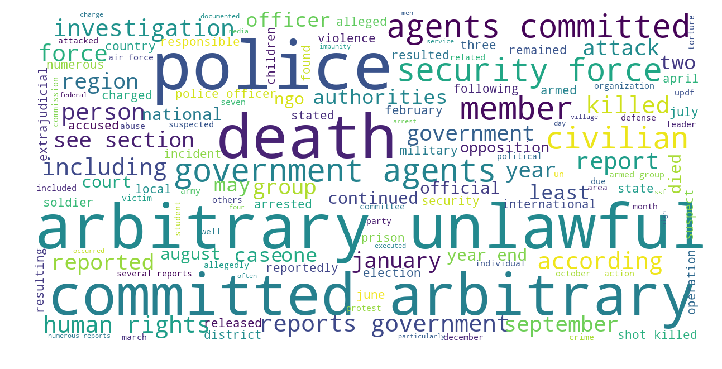

In [297]:


show_wordcloud(section_corpus)

# 3. 0: Part of Speach (POS) analysis on word 'reports'

## 3.1 Import 2018 all of africa reports

In [621]:
# import all text for Africa

text_folder = '../data/Custom_State_Dep_Reports/'

with open(text_folder+'2018_all_sections_africa.txt', 'r') as myfile:
  master_corpus = myfile.read()


In [739]:
# covert sentences into list items
text = master_corpus.replace('\n',' ') 
text =text.split('.')
text = [clean_text(i) for i in text]

# creat list of sentences with 'reports' mentioned
subs='reports'
res = [i for i in text if subs in i]
len(res)

1116

In [662]:
# download some additional nltk packages
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/garethwalker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/garethwalker/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 3.2: Try analysing sentences with 'reports'

In [1046]:



def return_qualifiers(sentence2,scan_breadth):
    
    # Tokenise sentence
    tokens = nltk.word_tokenize(sentence2)
    POS_data   = nltk.pos_tag(tokens)
    
    
    # Determin words prior to keyword to sample
    keyword_position = tokens.index('reports')
    scan_breadth       = max(0, keyword_position-scan_breadth)
    words_prior      = POS_data[scan_breadth:keyword_position]

    #search through these words for verbs, adjectives and determiners which qualify keyword
    
    POS_before=['RB','EX','VBN','VBD','DT','JJ','NN','NNS','according'] # civil soc orgs; also see https://www.clips.uantwerpen.be/pages/mbsp-tags
    result=[]
    for j in POS_before:
        match = [i for i in words_prior if j in i]
        result.append(match)
    
    # an addional search for verbs after reports (reports indicated, reports confired)
    
    verb_list = ['VB','VBN','VBZ','VBD']
    
    for verb in verb_list:   
        try:
            if POS_data[keyword_position+1][1] == verb:
                result.append(POS_data[keyword_position+1])
        except:
            pass
  

    return(result)

#VBD,VB
#print(Before_report)
#print(POS_data)


def return_details(sentence,scan_breadth):
    # Tokenise sentence
    tokens = nltk.word_tokenize(sentence)
    POS_data   = nltk.pos_tag(tokens)
    
    # Determin words after keyword to sample
    #keyword_position = tokens.index('reports')
    #scan_breadth = min(len(POS_data),keyword_position+scan_breadth)
    #words_after = POS_data[keyword_position+1:scan_breadth]

    # scan forwards for nouns NN, NNS, and Adjectives JJ and verbs VB VBD to describe report content
    POS_after=['NN','NNS','JJ','VBD','VBG'] # see see https://www.clips.uantwerpen.be/pages/mbsp-tags
    result=[]
    for j in POS_after:
        match = [i for i in POS_data if j in i]
        result.append(match)
    return(result)

print(return_qualifiers(res[1002],4))

print(return_details(res[1002],15))



[[], [], [], [('received', 'VBD')], [], [('regular', 'JJ')], [], [], []]
[[('expert', 'NN'), ('situation', 'NN'), ('sudan', 'NN'), ('s', 'NN'), ('section', 'NN'), ('rape', 'NN'), ('gender', 'NN'), ('violence', 'NN'), ('see', 'NN'), ('section', 'NN')], [('rights', 'NNS'), ('rights', 'NNS'), ('reports', 'NNS'), ('incidents', 'NNS')], [('international', 'JJ'), ('human', 'JJ'), ('unamid', 'JJ'), ('human', 'JJ'), ('regular', 'JJ'), ('sexual', 'JJ')], [('reported', 'VBD'), ('received', 'VBD')], []]


# 4.0 Use SVM to classify text

## 4.1 Use SVM to classify reports vs no reports

Using some labeled data I put together manually, this classfies sentences with 'reports' in the sentence as positive or negaitve

### 4.1.1 Import labled training data and all of africa 2018 text

In [1047]:

training_df=pd.read_csv('../data/NLP_training_set.csv')
training_df = training_df.drop(columns=['Unnamed: 0'])

training_df['Basic_Class']=training_df['Class']

training_df['Basic_Class'].replace(1,0,inplace=True)
training_df['Basic_Class'].replace(2,1,inplace=True)
training_df['Basic_Class'].replace(3,1,inplace=True)


### 4.1.2 Apply SVM classifier

In [797]:
from sklearn.model_selection import train_test_split


X = training_df['String']
y = training_df['Basic_Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


In [991]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=30, tol=None)),
               ])
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

### 4.1.3 Evaluate SVM classifier

In [795]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

accuracy 0.9373134328358209
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       164
           1       0.93      0.95      0.94       171

   micro avg       0.94      0.94      0.94       335
   macro avg       0.94      0.94      0.94       335
weighted avg       0.94      0.94      0.94       335

[[151  13]
 [  8 163]]


## 4.2 Use SVM to predict report section membership (hence type of offence)

now that Marie has pacred the africa section, I can look at how SVM performs on recognising types of transgessions

In [848]:
df_all_africa = pd.read_csv('../data/Custom_State_Dep_Reports/2018_all_sections_africa_PARCED.csv')

In [1049]:
df_train=pd.DataFrame(columns=['text','label'])

for i in range(len(df_all_africa.columns)-3): 
    df_extract = pd.DataFrame(columns=['text','label'])
    df_all_africa.iloc[:,i+3] = df_all_africa.iloc[:,i+3].astype(str)
    df_extract['text']=' '.join(df_all_africa.iloc[:,i+3]).replace('\n',' ').split('.')
    df_extract['label'] = df_all_africa.columns[i+3]
    df_train= df_train.append(df_extract)


In [1050]:
X = df_train['text']
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [1051]:
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

### 4.2.1: Evaluate model

In [1052]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

accuracy 0.6923897107823537
              precision    recall  f1-score   support

  Section_1a       0.44      0.19      0.27       125
  Section_1b       0.66      0.32      0.43        59
  Section_1c       0.70      0.72      0.71       657
  Section_1d       0.68      0.62      0.65       678
  Section_1e       0.67      0.66      0.66       530
  Section_1f       0.69      0.27      0.39        93
  Section_1g       0.49      0.23      0.31       139
  Section_2a       0.72      0.81      0.76       512
  Section_2b       0.68      0.40      0.50       175
  Section_2c       0.89      0.63      0.74        51
  Section_2d       0.77      0.74      0.76       455
   Section_3       0.69      0.75      0.72       394
   Section_4       0.74      0.67      0.70       263
   Section_5       0.71      0.43      0.54       187
   Section_6       0.65      0.90      0.75      1668
  Section_7a       0.80      0.81      0.81       432
  Section_7b       0.65      0.28      0.39       188

Performs better on some cataories than others, this is without text cleaning or parameter tuning, so it feels promissing

####  testing on classifying sections of Amnesty International

Women

In [899]:
test = "Reports of domestic violence increased; immediate protection orders had been issued by 1 June. In August, Judge Fildeze Hafizi was shot and killed in her car by her former husband. She had been granted a protection order in 2015 after he had beaten her. He was convicted and imprisoned in April 2016, but released in early 2017 under a general amnesty."
test = test.split('.')
y_pred = sgd.predict(test)
y_pred

In [910]:
test2 = 'Physical attacks against investigative journalists were perpetrated by organized criminals, or owners of private companies. In March, journalist Elvi Fundo was beaten in the capital, Tirana, by assailants believed to be associated with organized crime. In June, TV channel owner Erven Hyseni was shot dead in Vlora, along with a government official. In July, journalists claimed that defamation proceedings brought against two media outlets by High Court Judge Gjin Gjoni and his wife, businesswoman Elona Caushi, aimed to intimidate investigative journalists and encourage self-censorship.'
test2 = test2.split('.')
y_pred = sgd.predict(test2)
y_pred

In [914]:
test3 = 'No measures were taken to locate the body of Remzi Hoxha, a Macedonian Albanian who was forcibly disappeared by National Intelligence Service officials in 1995. No progress was reported towards the exhumation of the remains of around 6,000 people who had disappeared between 1945 and 1991.'
test3 = test3.split('.')
y_pred = sgd.predict(test3)
y_pred

In [918]:
test4 = 'Measures to ensure judicial independence were partially implemented. In June, two judicial associations appealed to the Constitutional Court against a vetting law, which sought to ensure judges’ and prosecutors’ independence from organized crime.'
test4 = test4.split('.')
y_pred = sgd.predict(test4)
y_pred

# 4. 3 Using SVM to predict CIRI scores

In [1141]:
data_df = pd.read_csv('../data/Custom_State_Dep_Reports/CIRI_Text_1999_2009.csv')


In [1142]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073 entries, 0 to 2072
Data columns (total 31 columns):
Unnamed: 0    2073 non-null int64
Text          2073 non-null object
Year          2073 non-null int64
UNCTRY        2025 non-null float64
CTRY          2073 non-null object
YEAR          2073 non-null int64
CIRI          2073 non-null int64
COW           2049 non-null float64
POLITY        2061 non-null float64
UNREG         2073 non-null int64
UNSUBREG      2073 non-null int64
PHYSINT       1895 non-null float64
DISAP         1919 non-null float64
KILL          1919 non-null float64
POLPRIS       1918 non-null float64
TORT          1919 non-null float64
OLD_EMPINX    1384 non-null float64
NEW_EMPINX    1897 non-null float64
ASSN          1919 non-null float64
FORMOV        2013 non-null float64
DOMMOV        2013 non-null float64
OLD_MOVE      1407 non-null float64
SPEECH        1919 non-null float64
ELECSD        1919 non-null float64
OLD_RELFRE    1402 non-null float64
NEW_REL

Update pipline with tuned parameters (mannually found through trial and error)

In [1155]:
sgd = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,3))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(class_weight = 'balanced', loss='hinge', penalty='l2', random_state=42, max_iter=30, tol=None)), #alpha=1e-3,
               ])

In [1164]:


def get_data(CIRI_Label):
    print("   Extracting Data")                   
    test_df = data_df[['Text',CIRI_Label]].dropna()
    states = data_df[CIRI_Label].unique()
    to_drop = [ -77.0, -66.0,-999.]
    new_states = [x for x in states if x not in to_drop]
    test_df = test_df[test_df[CIRI_Label].isin(new_states)]
    
    X = test_df['Text'].apply(lambda x: clean_text(x))
    y = test_df[CIRI_Label]
    #test_df[CIRI_Label].plot.hist()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
    return( X_train, X_test, y_train, y_test)

In [1179]:
CIRI_Labels_Predict = ['PHYSINT', 'DISAP','KILL', 'POLPRIS', 'TORT', 'OLD_EMPINX', 'NEW_EMPINX', 'ASSN', 'FORMOV','DOMMOV', 'OLD_MOVE', 'SPEECH', 'ELECSD', 'OLD_RELFRE', 'NEW_RELFRE','WORKER', 'WECON', 'WOPOL', 'WOSOC', 'INJUD']

df_model_perform = pd.DataFrame(columns =['Class','y_test','y_pred'])

for C_label in CIRI_Labels_Predict:
    
    print('V2 Analysing: ' + str(C_label))
    

    df_code_perform = pd.DataFrame(columns =['Class','y_test','y_pred'])

    X_train, X_test, y_train, y_test= get_data(C_label)
    print('   Fitting model')
    sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_test)
    print('   Accuracy: %s' % accuracy_score(y_pred, y_test))
    
    df_code_perform['y_test'] =  y_test
    df_code_perform['y_pred'] = y_pred
    df_code_perform['Class'] = str(C_label)
    df_model_perform = df_model_perform.append(df_code_perform)

V2 Analysing: PHYSINT
   Extracting Data
   Fitting model
   Accuracy: 0.5219683655536028
V2 Analysing: DISAP
   Extracting Data
   Fitting model
   Accuracy: 0.8787346221441125
V2 Analysing: KILL
   Extracting Data
   Fitting model
   Accuracy: 0.7631578947368421
V2 Analysing: POLPRIS
   Extracting Data
   Fitting model
   Accuracy: 0.8087719298245614
V2 Analysing: TORT
   Extracting Data
   Fitting model
   Accuracy: 0.8052631578947368
V2 Analysing: OLD_EMPINX
   Extracting Data
   Fitting model
   Accuracy: 0.5384615384615384
V2 Analysing: NEW_EMPINX
   Extracting Data
   Fitting model
   Accuracy: 0.39824561403508774
V2 Analysing: ASSN
   Extracting Data
   Fitting model
   Accuracy: 0.7929824561403509
V2 Analysing: FORMOV
   Extracting Data
   Fitting model
   Accuracy: 0.8712374581939799
V2 Analysing: DOMMOV
   Extracting Data
   Fitting model
   Accuracy: 0.8729096989966555
V2 Analysing: OLD_MOVE
   Extracting Data
   Fitting model
   Accuracy: 0.9112709832134293
V2 Analysing: S

In [1183]:
df_model_perform.to_csv('model_performance_report.csv')

In [1226]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

def performance_report(df, CIRI_label):
    df= df[df['Class']==CIRI_label]
    print('accuracy %s' % accuracy_score(df['y_pred'], df['y_test']))
    print(classification_report(df['y_test'],df['y_pred']))
    print(confusion_matrix(df['y_test'],df['y_pred']))
    
def generate_performance_db(df):
    labels = df['Class'].unique()
    df_performance =pd.DataFrame(columns = ['Class','Accuracy','Precision','Recall'])
    
    for i in range(len(labels)):
        label = labels[i]     
        df_of_int= df[df['Class']==label]
        
        df_performance.loc[i,'Class']     =  str(label)
        df_performance.loc[i,'Accuracy']  =  accuracy_score(df_of_int['y_pred'], df_of_int['y_test'])
        df_performance.loc[i,'Precision'] =  precision_score(df_of_int['y_pred'], df_of_int['y_test'],average='micro')
        df_performance.loc[i,'Recall']    =  recall_score(df_of_int['y_test'],df_of_int['y_pred'],average='micro')
        
    return df_performance

[Text(0, 0, 'PHYSINT'),
 Text(0, 0, 'DISAP'),
 Text(0, 0, 'KILL'),
 Text(0, 0, 'POLPRIS'),
 Text(0, 0, 'TORT'),
 Text(0, 0, 'OLD_EMPINX'),
 Text(0, 0, 'NEW_EMPINX'),
 Text(0, 0, 'ASSN'),
 Text(0, 0, 'FORMOV'),
 Text(0, 0, 'DOMMOV'),
 Text(0, 0, 'OLD_MOVE'),
 Text(0, 0, 'SPEECH'),
 Text(0, 0, 'ELECSD'),
 Text(0, 0, 'OLD_RELFRE'),
 Text(0, 0, 'NEW_RELFRE'),
 Text(0, 0, 'WORKER'),
 Text(0, 0, 'WECON'),
 Text(0, 0, 'WOPOL'),
 Text(0, 0, 'WOSOC'),
 Text(0, 0, 'INJUD')]

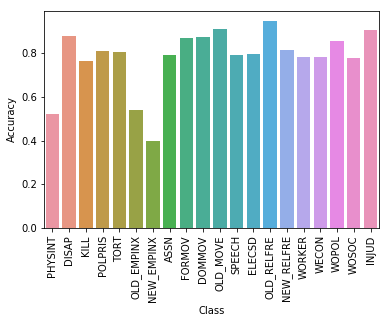

In [1240]:
from seaborn import barplot

performance = generate_performance_db(df_model_perform)

results = barplot(x=performance['Class'],y=performance['Accuracy'])
results.set_xticklabels(results.get_xticklabels(), rotation=90)

In [1242]:
performance_report(df_model_perform, 'PHYSINT')




accuracy 0.5219683655536028
              precision    recall  f1-score   support

         0.0       0.71      0.62      0.67        24
         1.0       0.47      0.52      0.49        27
         2.0       0.48      0.43      0.45        51
         3.0       0.23      0.25      0.24        40
         4.0       0.39      0.44      0.41        72
         5.0       0.51      0.51      0.51        82
         6.0       0.41      0.35      0.38        82
         7.0       0.68      0.68      0.68       119
         8.0       0.70      0.72      0.71        72

   micro avg       0.52      0.52      0.52       569
   macro avg       0.51      0.50      0.51       569
weighted avg       0.52      0.52      0.52       569

[[15  7  2  0  0  0  0  0  0]
 [ 4 14  5  0  2  2  0  0  0]
 [ 2  7 22 10  9  1  0  0  0]
 [ 0  1 14 10  8  4  2  1  0]
 [ 0  1  3 17 32 15  3  1  0]
 [ 0  0  0  4 22 42 13  1  0]
 [ 0  0  0  2  7 17 29 21  6]
 [ 0  0  0  0  2  1 19 81 16]
 [ 0  0  0  0  1  1  4 14 5

In [1146]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))




accuracy 0.7929824561403509
              precision    recall  f1-score   support

         0.0       0.82      0.75      0.78       127
         1.0       0.65      0.75      0.70       172
         2.0       0.89      0.84      0.86       271

   micro avg       0.79      0.79      0.79       570
   macro avg       0.79      0.78      0.78       570
weighted avg       0.80      0.79      0.80       570

[[ 95  31   1]
 [ 15 129  28]
 [  6  37 228]]


In [957]:
# Max itter 30
    #no stop words = 73.2
    #with stop words = 77.8
        # with ngram range of 1 to 3 : 79.3
# Max itter 60    
    #with stop words = 77.8
        # with ngram range of 1 to 3 : 79.0
        
# no class balance : 81.433
# class balance: 82.353

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 168
Data columns (total 2 columns):
Text      139 non-null object
WORKER    139 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


In [1247]:
df= df_model_perform[df_model_perform['Class']=='PHYSINT']
array = confusion_matrix(df['y_test'],df['y_pred'])




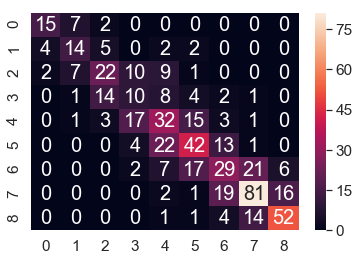

In [1252]:
import seaborn as sn
df_cm = pd.DataFrame(array, range(9),
                  range(9))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 20})# font size





# Extracting feature importance from SGD

In [1290]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_[0].ravel()  # I think you need to index for each class within the lable
    
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    print('Top Positive Coefficients: ' + str(top_positive_coefficients))
    
    top_negative_coefficients = np.argsort(coef)[:top_features]
    print('Top Negative Coefficients: ' + str(top_negative_coefficients))
    
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]] 
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    print('Feature Names: ' + str(feature_names))
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    





87792
87792
Top Positive Coefficients: [  507  9926 78586 71180  6126 48075 79871 67502 22973 23751 18788 80410
  6580 71554  2380 37457 60971 62402  4349 78730]
Top Negative Coefficients: [67152 28796  3203 24997 39459 25001 63250 66537 63537 80083 28795 76793
 30938 30431 50729 25004  5060 60144 60608 32655]
Feature Names: ['00' '000' '0000' ... 'zyrianovsk' 'zyrnagjiu' 'zziwa']


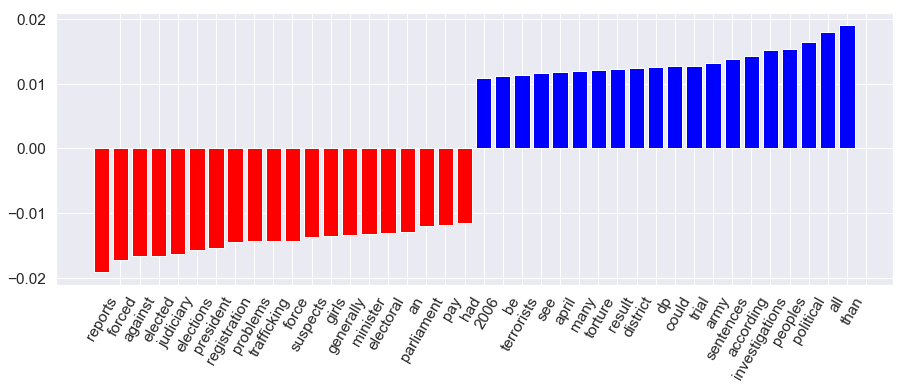

In [1292]:
cv = CountVectorizer()

#data, X_test, y_train, y_test= get_data('POLPRIS')


cv.fit(data)
print (len(cv.vocabulary_))
print (len(cv.get_feature_names()))
#X_train = cv.transform(data)

#svm = LinearSVC()
#svm.fit(X_train, y_train)


#coef = svm.coef_.ravel()
plot_coefficients(svm, cv.get_feature_names())



In [1296]:
vec= CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,3))
tf_idf = TfidfTransformer()
clf = SGDClassifier(class_weight = 'balanced', loss='hinge', penalty='l2', random_state=42, max_iter=30, tol=None) #alpha=1e-3,

vectorised = vec.fit_transform(data)
vectorised = tf_idf.fit_transform(vectorised)





In [1298]:
clf.fit(vectorised, y_train)

/Users/garethwalker/anaconda3/envs/DataChallenge/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=30,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Top Positive Coefficients: [ 151520 3228550  329877 3440825  954052 3801351 3221075 5267796 3045455
 3882646  375067 2134383 5947799 5679728  644465  482156 3539475 4359206
 3498458 2492512]
Top Negative Coefficients: [ 115801 1408501 5144408 2459565 5804657  475164 2290375 4121948 4440221
 4654515 2254818 5098776 3035341 5161123 3283574 5147943 2877590 3679120
 4318776 4129320]
Feature Names: ['00' '00 00' '00 00 authorities' ... 'zziwa' 'zziwa arrested'
 'zziwa arrested held']


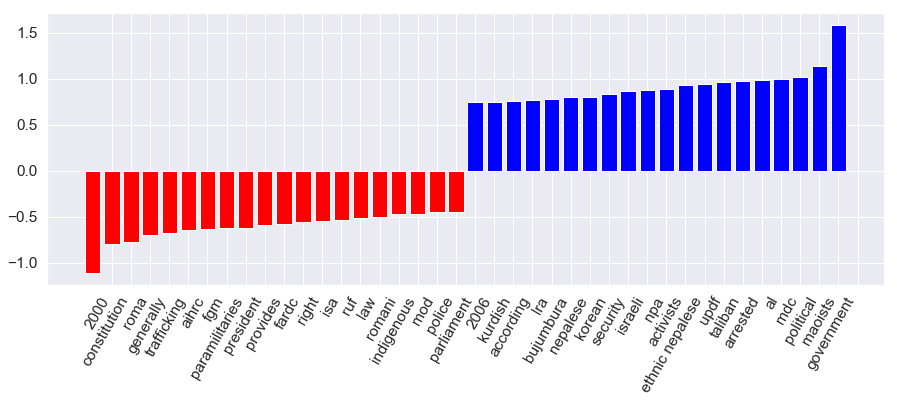

In [1299]:
plot_coefficients(clf, vec.get_feature_names())

looks like location based data is playing too much of a role in analysis

# attempt to remove location variables from corpus

In [1373]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

def remove_location_ents(text):
    text = text.replace('\n',' ')
    text = text.replace( "\"", '' )
    doc= nlp(text)
    drops = ['GPE','NORP','ORG','PERSON']
    GPEs = [x.text for x in doc.ents if x.label_ in drops]
    for word in GPEs:
        text = text.replace(word, " ")
    return text

In [1374]:
test = remove_location_ents(data_df['Text'][0])

In [1368]:
doc=nlp(test)
print([(X.text, X.label_) for X in doc.ents])

[('  ', 'ORG'), (' ', 'PERSON'), ('April 4, 1996', 'DATE'), (' ', 'PERSON'), ('  ', 'ORG'), ('  ', 'ORG'), ('1972 to 1989', 'DATE'), ('1990-91', 'DATE'), ('19', 'CARDINAL'), ('March 30', 'DATE'), ('27', 'CARDINAL'), (' ', 'LOC'), ('42', 'CARDINAL'), ('41', 'CARDINAL'), ('  ', 'ORG'), ('  ', 'ORG'), ('  ', 'ORG'), ('  ', 'ORG'), ('the Ministry of   ', 'ORG'), ('below $400', 'MONEY'), ('  ', 'ORG'), ('  ', 'ORG'), ('  ', 'ORG'), ('previous years', 'DATE'), ('4 percent', 'PERCENT'), ('3.5 percent', 'PERCENT'), ('August', 'DATE'), ('  ', 'ORG'), ('  ', 'ORG'), ('1998', 'DATE'), ('the year', 'DATE'), ('  ', 'ORG'), ('  ', 'ORG'), ('  ', 'ORG'), (' ', 'ORG'), ('Florent Adoko', 'PERSON'), ('  ', 'ORG'), ('January 1998', 'DATE'), ('the same day', 'DATE'), (' ', 'NORP'), (' ', 'NORP'), ('May 1998', 'DATE'), ('previous years', 'DATE'), ('  ', 'ORG'), ('100', 'CARDINAL'), ('  ', 'LOC'), ('between March and October', 'DATE'), ('  ', 'ORG'), (' ', 'ORG'), ('  ', 'NORP'), ('Constitution', 'LAW'), ('

In [1375]:
test

"  is a constitutional democracy headed by President  , who was inaugurated on April 4, 1996, after elections that generally were viewed as free and fair. President  , who ruled   as a   military dictator from 1972 to 1989, succeeded his democratically elected predecessor and continued the civilian, democratic rule begun in the 1990-91 constitutional process that ended his previous reign. There are 19 political parties represented in the unicameral, 83-member  . The March 30 parliamentary elections, which were free, fair, and transparent resulted in significant gains by the opposition, notably the party of former President  , which gained 27 seats in  . Although a loose alliance of progovernment deputies holds a 42 to 41 seat majority, some progovernment deputies side with the opposition, depending on the issue. Consequently, legislative power is shared between opposition and progovernment forces. For example the President of the   belongs to an opposition party. The   respects the con

In [1334]:
text = data_df['Text'][0]

In [1361]:
test

' , who was inaugurated on April 4, 1996, after elections that generally were viewed as free and fair. President  , who ruled   as a   military dictator from 1972 to 1989, succeeded his democratically elected predecessor and continued the civilian, democratic rule begun in the 1990-91 constitutional process that ended his previous reign. There are 19 political parties represented in the unicameral, 83-member  . The March 30 parliamentary elections, which were free, fair, and transparent resulted in significant gains by the opposition, notably the party of former President Nicephore Soglo, which gained 27 seats in  . Although a loose alliance of progovernment deputies holds a 42 to 41 seat majority, some progovernment deputies side with the opposition, depending on the issue. Consequently, legislative power is shared between opposition and progovernment forces. For example the President of the   belongs to an opposition party. The   respects the constitutional provision for an independe

', who was inaugurated on April 4, 1996, after elections that generally were viewed as free and fair. President Kerekou, who ruled Benin as a Socialist military dictator from 1972 to 1989, succeeded his democratically elected predecessor and continued the civilian, democratic rule begun in the 1990-91 constitutional process that ended his previous reign. There are 19 political parties represented in the unicameral, 83-member National Assembly. The March 30 parliamentary elections, which were free, fair, and transparent resulted in significant gains by the opposition, notably the party of former President Nicephore Soglo, which gained 27 seats in Parliament. Although a loose alliance of progovernment deputies holds a 42 to 41 seat majority, some progovernment deputies side with the opposition, depending on the issue. Consequently, legislative power is shared between opposition and progovernment forces. For example the President of the National Assembly belongs to an opposition party. Th